In [2]:
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import matplotlib.pyplot as plt



In [3]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow import keras
from random import randint

In [4]:
default_dir = "C:/Users/Msys/virtual_env/env2/Alzheimer_s Dataset"
root_dir = "."
#trian_dir = default_dir + "/train"
train_dir = default_dir + "/train"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
#copy_tree(train_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))



Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176 

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [8]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 5121 images belonging to 4 classes.


## Visualization

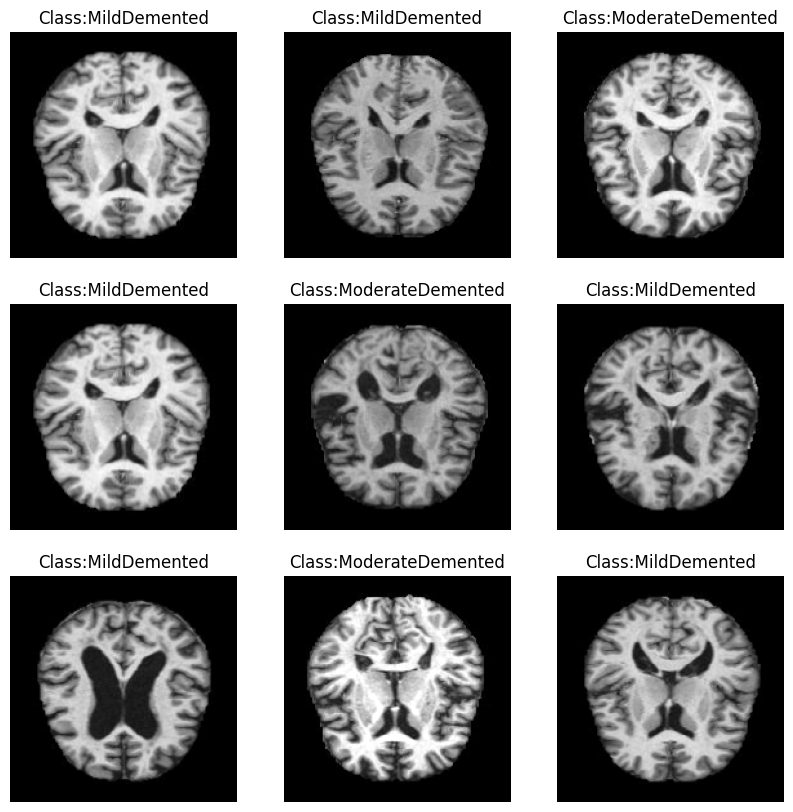

In [9]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

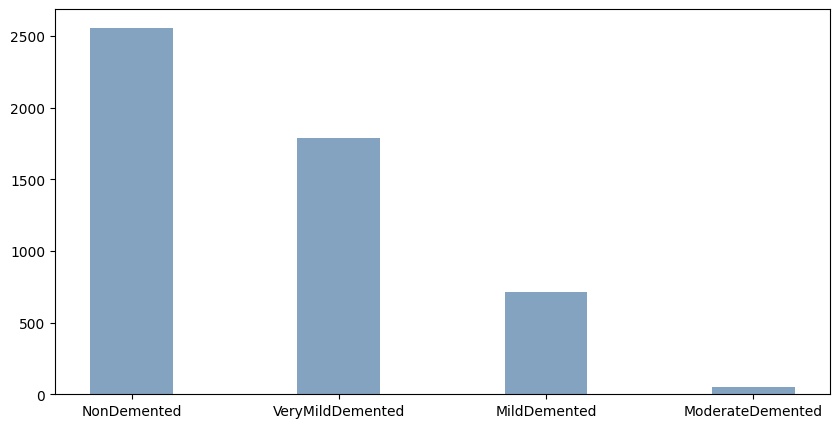

In [10]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [11]:
train_data, train_labels = train_dataset.next()

In [12]:
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [13]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [15]:
model = keras.models.Sequential([
 keras.Input(shape=train_data.shape[1:]),
            keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),

            keras.layers.Dropout(0.5),
            keras.layers.Dense(4, activation="softmax")])





In [16]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [17]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)


Epoch 1/50
205/205 [==============================] - 473s 2s/step - loss: 1.0160 - acc: 0.5323 - auc: 0.8080 - val_loss: 0.6068 - val_acc: 0.7608 - val_auc: 0.9428
Epoch 2/50
205/205 [==============================] - 468s 2s/step - loss: 0.5594 - acc: 0.7516 - auc: 0.9423 - val_loss: 0.4351 - val_acc: 0.8157 - val_auc: 0.9676
Epoch 3/50
205/205 [==============================] - 495s 2s/step - loss: 0.4120 - acc: 0.8195 - auc: 0.9690 - val_loss: 0.3223 - val_acc: 0.8646 - val_auc: 0.9803
Epoch 4/50
205/205 [==============================] - 519s 3s/step - loss: 0.3340 - acc: 0.8613 - auc: 0.9794 - val_loss: 0.2757 - val_acc: 0.8822 - val_auc: 0.9862
Epoch 5/50
205/205 [==============================] - 540s 3s/step - loss: 0.2523 - acc: 0.8964 - auc: 0.9879 - val_loss: 0.2352 - val_acc: 0.8987 - val_auc: 0.9897
Epoch 6/50
205/205 [==============================] - 496s 2s/step - loss: 0.2138 - acc: 0.9126 - auc: 0.9912 - val_loss: 0.2122 - val_acc: 0.9121 - val_auc: 0.9910
Epoch 7/50

In [18]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

64/64 [==============================] - 24s 368ms/step - loss: 0.2694 - acc: 0.9536 - auc: 0.9867
Loss:  0.2694113850593567
Accuracy:  0.95361328125


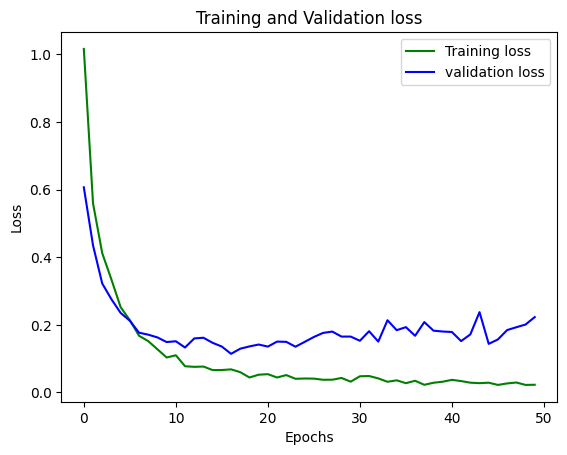

In [19]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

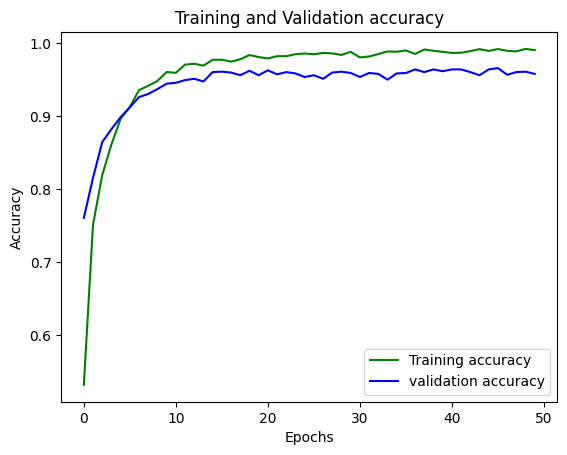

In [20]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
model.save('my_tenserflow_model.h5')

c:\Users\Msys\virtual_env\env2\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
